In [123]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import matplotlib as mpl

In [2]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

# Queries
* * *
### Overall Completion Rate

In [ ]:
#Aggregate any type of activity for each user,course tuple.
#Pull in the course start date and evaluate whether that happens before or after user enrollment

DROP TABLE IF EXISTS ahemphill.user_activity_agg;
CREATE TABLE ahemphill.user_activity_agg AS

SELECT
	a.user_id,
	a.course_id,
	date(a.first_enrollment_time) AS user_enrollment_date,
	b.date AS activity_date,
	c.start_time AS course_start_date,
	CASE WHEN date(a.first_enrollment_time) < date(c.start_time) 
	THEN date(c.start_time) ELSE date(a.first_enrollment_time) END AS first_eligible_activity_date,
	c.pacing_type,
	c.level_type,
	c.org_id,
	COUNT(b.date) AS cnt_activity
FROM 
	d_user_course a
LEFT JOIN
	f_user_activity b
ON
	a.user_id = b.user_id
	AND a.course_id = b.course_id
LEFT JOIN
	d_course c
ON
	a.course_id = c.course_id
WHERE 
	c.end_time BETWEEN '2016-01-01' AND '2016-11-01'
GROUP BY 1,2,3,4,5,6,7,8,9;

#Take the date difference of each piece of activity from the first day that the user could have shown activity
#Assign boolean to each date range and take the max to get a single row per user,course tuple


DROP TABLE IF EXISTS ahemphill.user_activity_over_time;
CREATE TABLE ahemphill.user_activity_over_time AS

SELECT
	user_id,
	course_id,
	user_enrollment_date,
	activity_date,
	course_start_date,
	first_eligible_activity_date,
	pacing_type,
	level_type,
	org_id,
	count(distinct activity_date) AS days_active,
	MAX(active_7d) AS active_7d,
	MAX(active_14d) AS active_14d,
	MAX(active_30d) AS active_30d,
	MAX(active_60d) AS active_60d,
	MAX(active_90d) AS active_90d,
	MAX(active_180d) AS active_180d,
	MAX(active_ever) AS active_ever

FROM
(
	SELECT 
		*,
		DATEDIFF('day',date(first_eligible_activity_date),activity_date) AS activity_days_from_course_start,
		CASE WHEN DATEDIFF('day',date(first_eligible_activity_date),activity_date) BETWEEN 0 AND 7 THEN 1 ELSE 0 END AS active_7d,
		CASE WHEN DATEDIFF('day',date(first_eligible_activity_date),activity_date) BETWEEN 7 AND 14 THEN 1 ELSE 0 END AS active_14d,
		CASE WHEN DATEDIFF('day',date(first_eligible_activity_date),activity_date) BETWEEN 14 AND 30 THEN 1 ELSE 0 END AS active_30d,
		CASE WHEN DATEDIFF('day',date(first_eligible_activity_date),activity_date) BETWEEN 30 AND 60 THEN 1 ELSE 0 END AS active_60d,
		CASE WHEN DATEDIFF('day',date(first_eligible_activity_date),activity_date) BETWEEN 60 AND 90 THEN 1 ELSE 0 END AS active_90d,
		CASE WHEN DATEDIFF('day',date(first_eligible_activity_date),activity_date) BETWEEN 90 AND 180 THEN 1 ELSE 0 END AS active_180d,
		CASE WHEN DATEDIFF('day',date(first_eligible_activity_date),activity_date) BETWEEN 0 AND 365 THEN 1 ELSE 0 END AS active_ever
	FROM 
		ahemphill.user_activity_agg
) a
GROUP BY 1,2,3,4,5,6,7,8,9;

#Take the sum of activity per course to understand activity drop off over time

DROP TABLE IF EXISTS ahemphill.user_activity_over_time_summary;
CREATE TABLE ahemphill.user_activity_over_time_summary AS

SELECT 
	course_id,
	COUNT(1) AS cnt_enrolls,
	SUM(active_ever) AS cnt_ever_active,
	SUM(active_7d) AS cnt_7d_active,
	SUM(active_14d) AS cnt_14d_active,
	SUM(active_30d) AS cnt_30d_active,
	SUM(active_60d) AS cnt_60d_active,
	SUM(active_90d) AS cnt_90d_active,
	SUM(active_180d) AS cnt_180d_active
FROM 
	ahemphill.user_activity_over_time
GROUP BY
	course_id;

In [5]:
activity_query = """

SELECT
	a.*,
    b.subject_title,
    c.pacing_type,
    c.level_type,
    c.org_id
FROM 
    ahemphill.user_activity_over_time_summary a
LEFT JOIN
    (
	SELECT
		a.course_id,
        a.subject_title,
		row_number() OVER (partition by a.course_id order by random()) AS rank
	FROM
		production.d_course_subjects a
) b
ON a.course_id = b.course_id
LEFT JOIN
        production.d_course c
ON a.course_id = c.course_id
WHERE 
	b.rank = 1 OR b.rank IS NULL

"""

In [6]:
connection = vertica_python.connect(**conn_info)
    
cur = connection.cursor('dict')
cur.execute(activity_query)
extract = cur.fetchall()
activity_df = pd.DataFrame(extract)


connection.close()

In [7]:
activity_df.head()

,cnt_14d_active,cnt_180d_active,cnt_30d_active,cnt_60d_active,cnt_7d_active,cnt_90d_active,cnt_enrolls,cnt_ever_active,course_id,level_type,org_id,pacing_type,subject_title
0,405,605,460,492,1826,397,41402,3612,ANUx/ANU-ASTRO3x/4T2014,Intermediate,ANUx,self_paced,None
1,1696,1775,1806,1321,5546,989,55945,10356,ANUx/ANU-ASTRO4x/1T2015,Intermediate,ANUx,self_paced,None
2,375,147,368,344,772,176,5871,1190,BerkeleyX/BJC.3x/1T2016,Introductory,BerkeleyX,instructor_paced,None
3,240,99,306,213,554,90,5106,848,BerkeleyX/BJC.4x/1T2016,Introductory,BerkeleyX,instructor_paced,None
4,846,92,651,239,1738,93,7733,2070,BerkeleyX/ColWri3.4x/1T2015,Introductory,BerkeleyX,instructor_paced,Humanities


In [9]:
activity_df['%7d_active'] = activity_df['cnt_7d_active']*100.0/activity_df['cnt_enrolls']
activity_df['%14d_active'] = activity_df['cnt_14d_active']*100.0/activity_df['cnt_enrolls']
activity_df['%30d_active'] = activity_df['cnt_30d_active']*100.0/activity_df['cnt_enrolls']
activity_df['%60d_active'] = activity_df['cnt_60d_active']*100.0/activity_df['cnt_enrolls']
activity_df['%90d_active'] = activity_df['cnt_90d_active']*100.0/activity_df['cnt_enrolls']
activity_df['%180d_active'] = activity_df['cnt_180d_active']*100.0/activity_df['cnt_enrolls']

In [13]:
activity_df['%_change_7_14d'] = (activity_df['%7d_active'] - activity_df['%14d_active'])*100.0/activity_df['%7d_active']

In [37]:
activity_df_filtered = activity_df[activity_df.cnt_enrolls>5000]

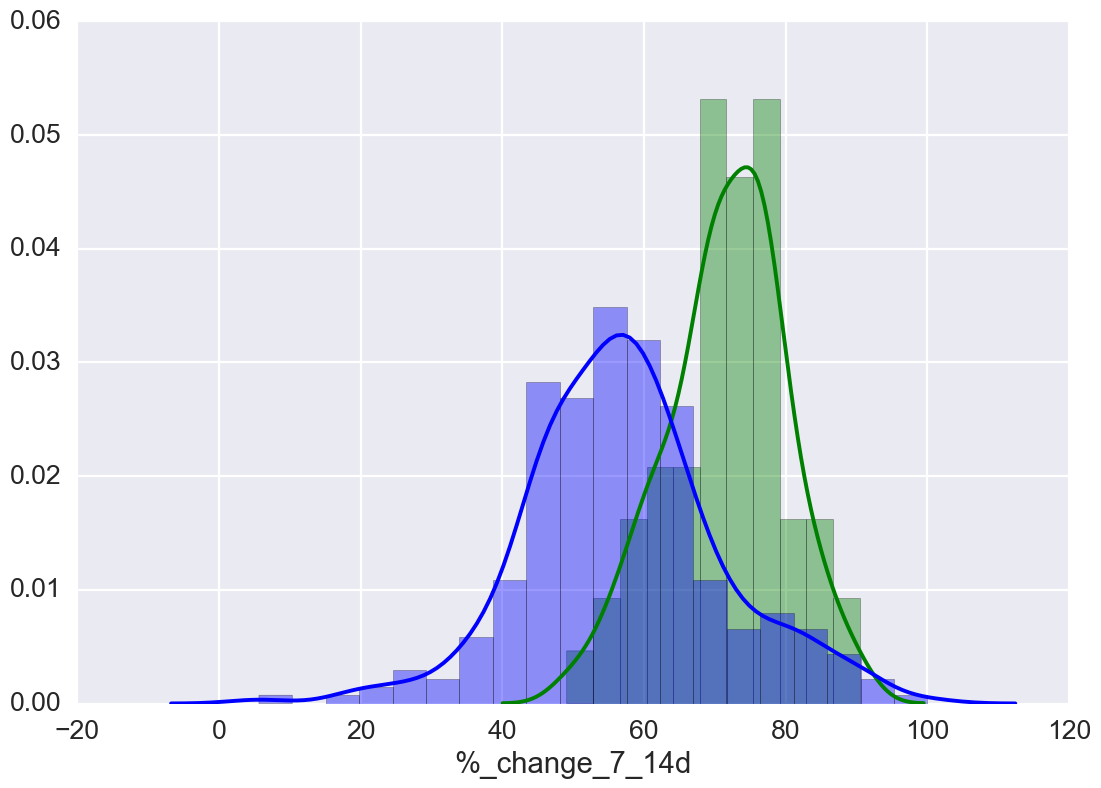

In [208]:
sns.distplot(activity_df_filtered[activity_df_filtered['pacing_type']=='self_paced']['%_change_7_14d'],hist=True,color='g')
sns.distplot(activity_df_filtered[activity_df_filtered['pacing_type']!='self_paced']['%_change_7_14d'],hist=True,color='b')

In [201]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
xkcd = sns.xkcd_palette(colors)
sns.set_context("poster", font_scale=1.2)

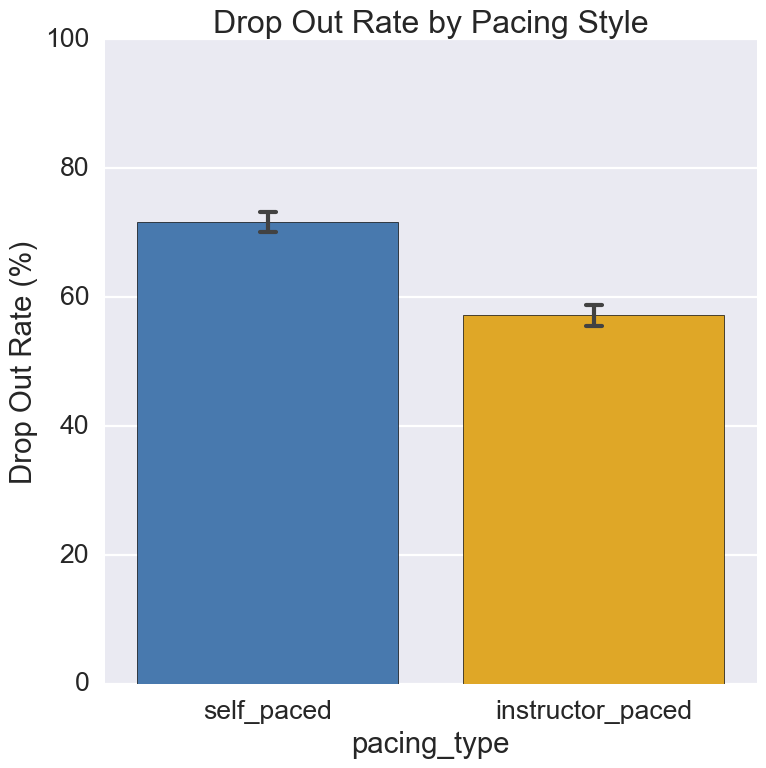

In [204]:
ax = sns.factorplot(data=activity_df_filtered, x='pacing_type', y='%_change_7_14d', kind='bar', size =8, errwidth=3
                   , capsize=0.05, palette=xkcd)
ax.set(ylim=(0,100),ylabel='Drop Out Rate (%)', title='Drop Out Rate by Pacing Style')

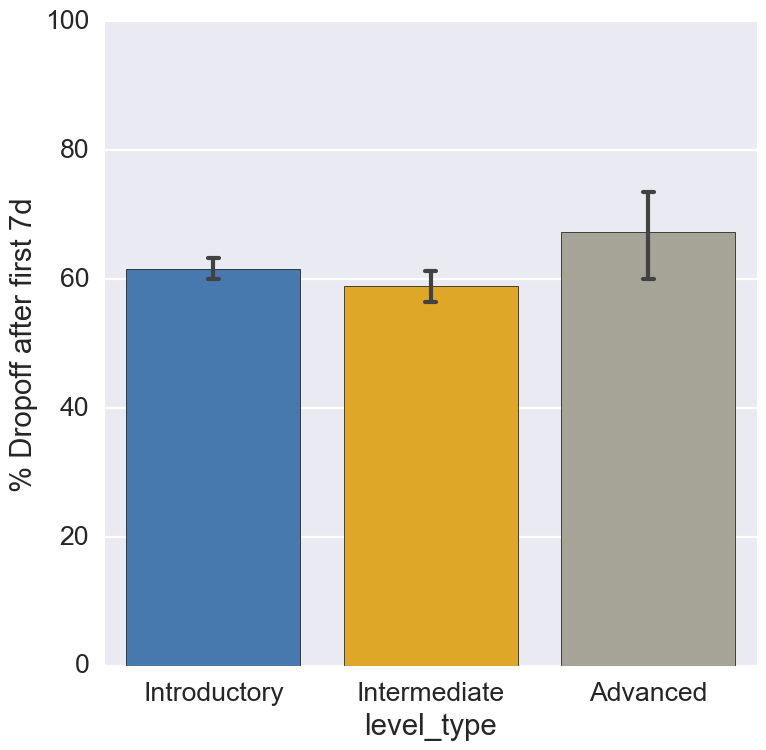

In [223]:
ax = sns.factorplot(data=activity_df_filtered, x='level_type', y='%_change_7_14d', kind='bar', size =8, errwidth=3
                   , capsize=0.05, palette=xkcd, order=['Introductory','Intermediate','Advanced'])
ax.set(ylim=(0,100),ylabel='% Dropoff after first 7d')

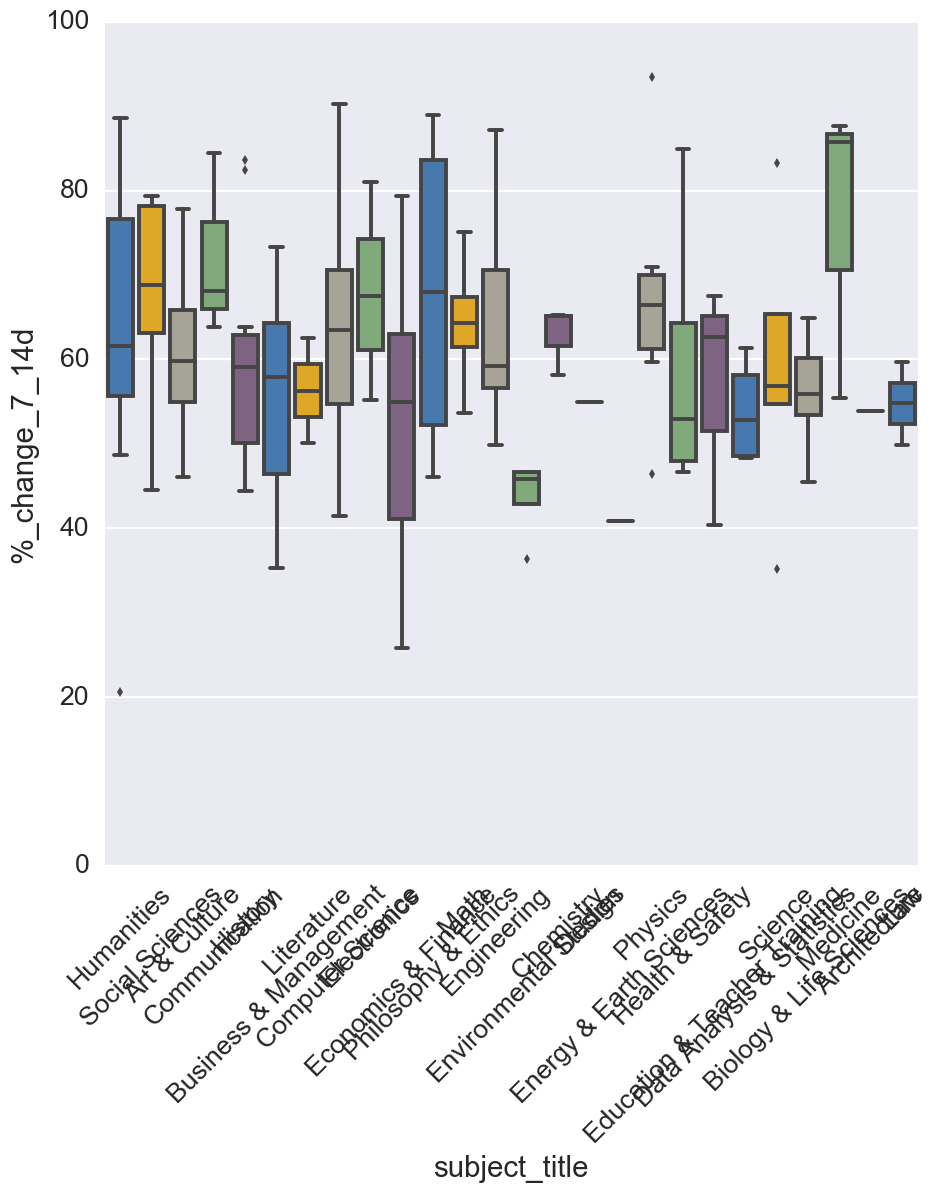

In [209]:
ax = sns.factorplot(data=activity_df_filtered, x='subject_title', y='%_change_7_14d', kind='box', size = 10, palette=xkcd)
ax.set(ylim=(0,100))
ax.set_xticklabels(rotation=45)

In [69]:
activity_df_filtered_temp = activity_df_filtered

days_list = [7,14,30,60,90]

In [79]:
def stack_this_df(days_list):
    activity_df_filtered_stacked = pd.DataFrame()
    for i in days_list:
        col = '%' + '%id_active' % i
        activity_df_filtered_temp['pct_active_users'] = activity_df_filtered[col]
        activity_df_filtered_temp['days'] = i
        activity_df_filtered_stacked = activity_df_filtered_stacked.append(activity_df_filtered_temp)
    return activity_df_filtered_stacked

In [80]:
activity_df_filtered_stacked = stack_this_df(days_list)

/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


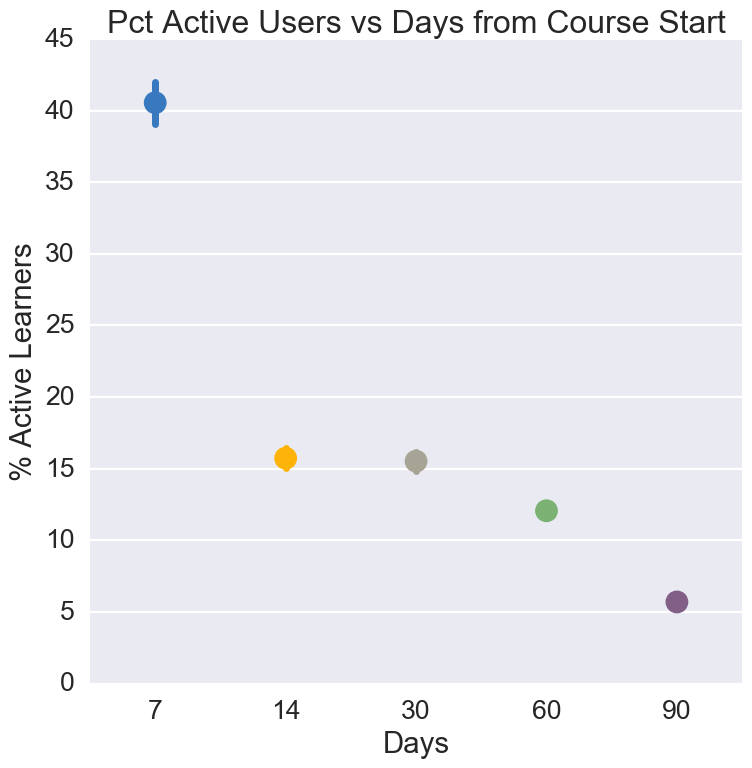

In [212]:
ax = sns.factorplot(data=activity_df_filtered_stacked, x='days', y='pct_active_users', size =8, palette=xkcd)
ax.set(title = 'Pct Active Users vs Days from Course Start', xlabel='Days', ylabel='% Active Learners')

In [230]:
activity_df_filtered_stacked[.head()

,cnt_14d_active,cnt_180d_active,cnt_30d_active,cnt_60d_active,cnt_7d_active,cnt_90d_active,cnt_enrolls,cnt_ever_active,course_id,level_type,...,%14d_active,%30d_active,%60d_active,%90d_active,%180d_active,%_change_7_14d,dropoff_rate,dropoff_rate_days,pct_active_users,days
0,405,605,460,492,1826,397,41402,3612,ANUx/ANU-ASTRO3x/4T2014,Intermediate,...,0.978214,1.111057,1.188348,0.958891,1.461282,77.820372,0.958891,90,4.410415,7
1,1696,1775,1806,1321,5546,989,55945,10356,ANUx/ANU-ASTRO4x/1T2015,Intermediate,...,3.031549,3.228171,2.361248,1.767808,3.172759,69.419401,1.767808,90,9.913308,7
2,375,147,368,344,772,176,5871,1190,BerkeleyX/BJC.3x/1T2016,Introductory,...,6.387328,6.268097,5.859308,2.997786,2.503832,51.424870,2.997786,90,13.149378,7
3,240,99,306,213,554,90,5106,848,BerkeleyX/BJC.4x/1T2016,Introductory,...,4.700353,5.992949,4.171563,1.762632,1.938895,56.678700,1.762632,90,10.849980,7
4,846,92,651,239,1738,93,7733,2070,BerkeleyX/ColWri3.4x/1T2015,Introductory,...,10.940127,8.418466,3.090650,1.202638,1.189706,51.323360,1.202638,90,22.475107,7


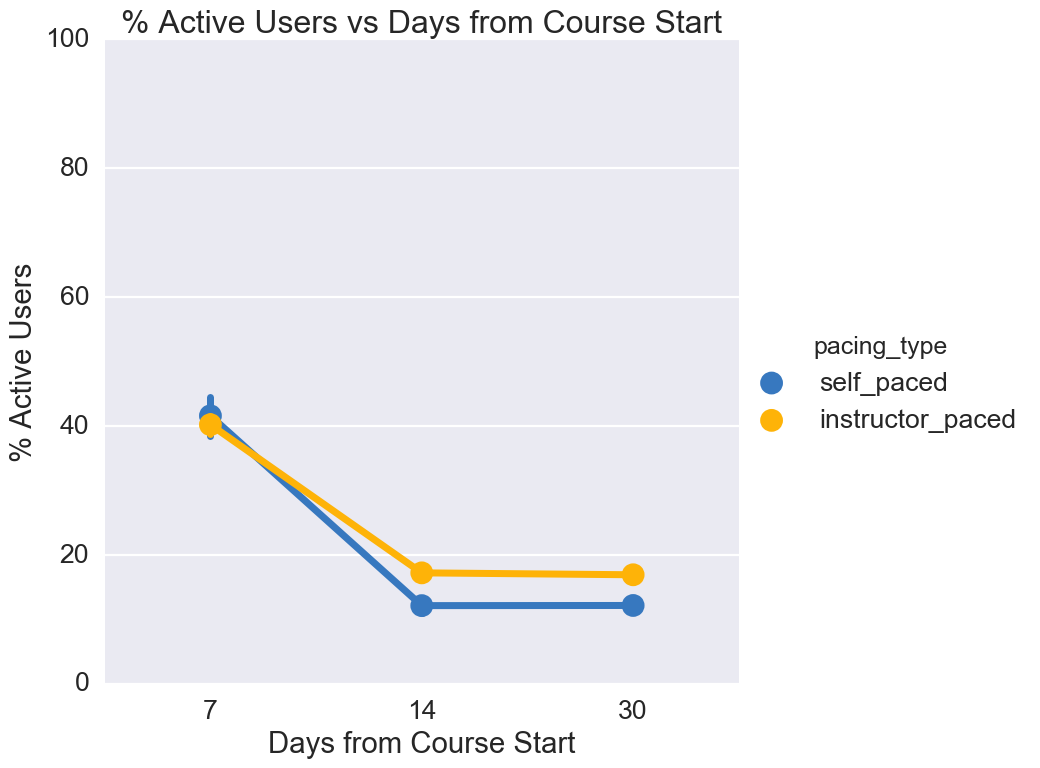

In [231]:
ax = sns.factorplot(data=activity_df_filtered_stacked[activity_df_filtered_stacked.days <= 30], x='days', y='pct_active_users', 
                size =8, hue='pacing_type', kind='point', palette=xkcd)
ax.set(title = '% Active Users vs Days from Course Start', xlabel='Days from Course Start', 
       ylabel='% Active Users', ylim=(0,100))

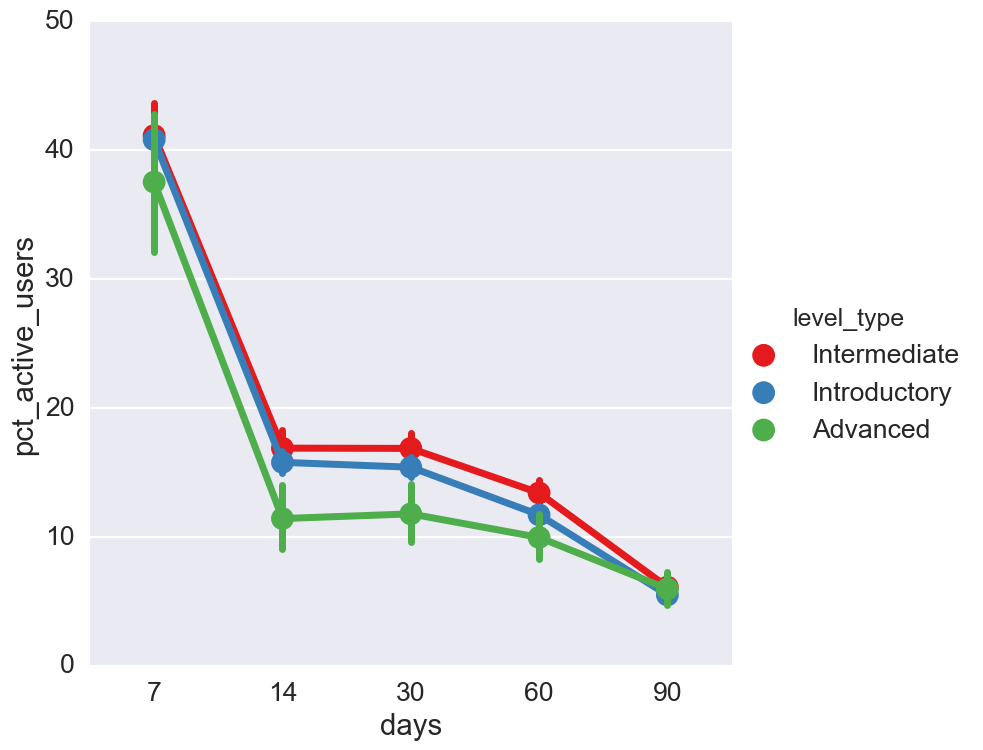

In [222]:
sns.factorplot(data=activity_df_filtered_stacked, x='days', y='pct_active_users', 
                size =8, hue='level_type', palette="Set1")

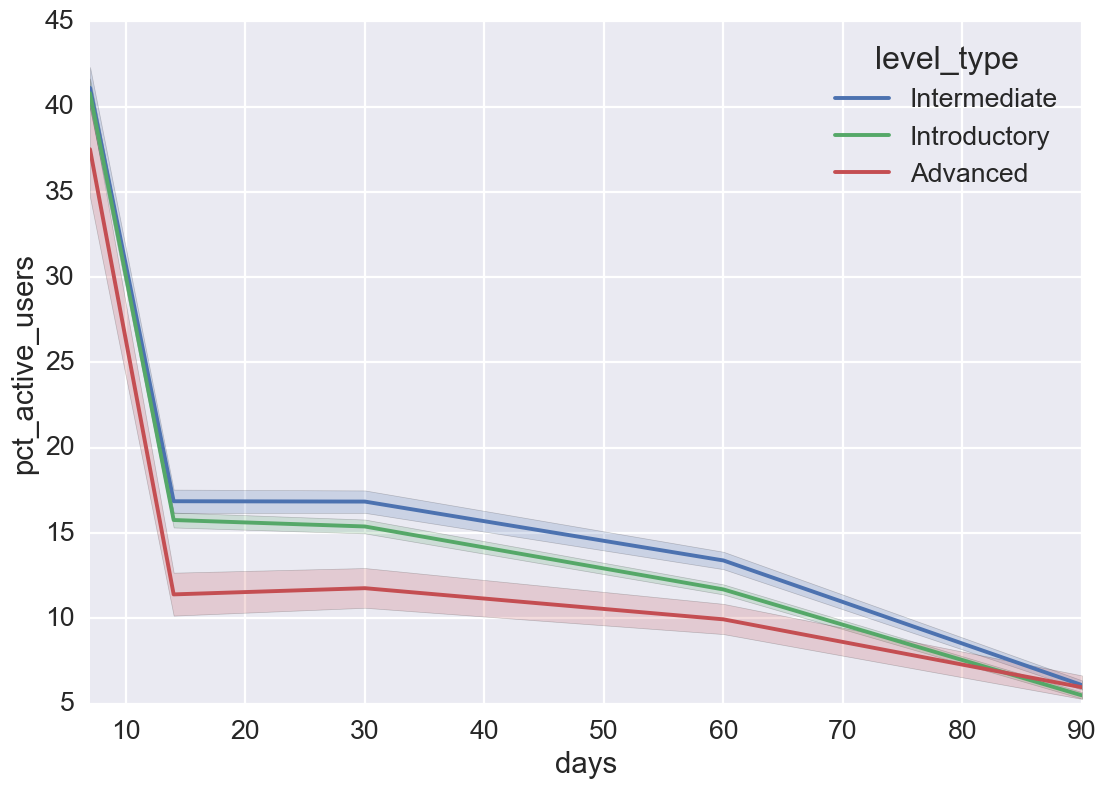

In [218]:
sns.tsplot(data=activity_df_filtered_stacked, time="days",
           condition="level_type", value="pct_active_users")